In [90]:
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

In [ ]:
def local_level(num_timesteps=60, init_mu=10, 
                s_obs = 2, s_level=1,
                seeded=False, seed=None):

    if seeded:
        np.random.seed(seed)
    
    mu = np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)
    
    mu_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    obs_err = np.random.normal(loc=0, scale=1, size=num_timesteps)

    # Get seasonal effects
    mu[0] = init_mu

    for t in range(num_timesteps):
        mu[t+1] = mu[t] + s_level * mu_err[t]
        y[t] = mu[t] + s_obs * obs_err[t]

    return mu, y

In [ ]:
N = 100
s_obs = 2
s_level = 1
init_mu = 0

mu, y = local_level(num_timesteps=N, init_mu=init_mu, s_obs=s_obs, s_level=s_level, seeded=True, seed=5)

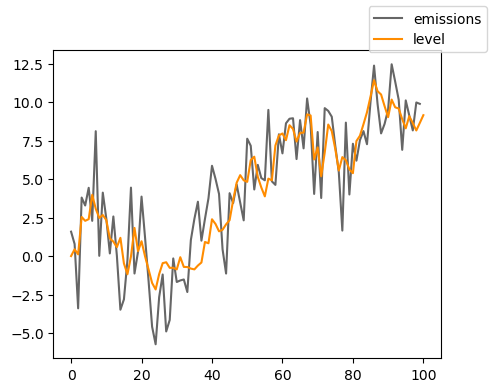

In [12]:
fig, ax = plt.subplots(1, figsize=(5,4))
ax.plot(y, label='emissions', color='k', alpha=.6)
ax.plot(mu, label = 'level', color='darkorange')
fig.legend()

In [43]:
model_res.params

array([8.43133725])

In [44]:
model = sm.tsa.UnobservedComponents(y, 
                                    level=True, stochastic_level=True
                                    )
model_res = model.fit()
model_res.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50478D+00    |proj g|=  9.95649D-02

At iterate    5    f=  2.46007D+00    |proj g|=  4.53679D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      6      7      1     0     0   2.324D-07   2.460D+00
  F =   2.4600684329741687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                    random walk   Log Likelihood                -246.007
Date:                Thu, 16 Feb 2023   AIC                            494.014
Time:                        19:15:38   BIC                            496.609
Sample:                             0   HQIC                           495.064
                                - 100                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level     8.4313      1.224      6.891      0.000       6.033      10.829
===================================================================================
Ljung-Box (L1) (Q):                  17.74   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.00   Prob(JB):                         0.79
Heteroskedasticity (H):               0.73   Skew:                             0.16
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

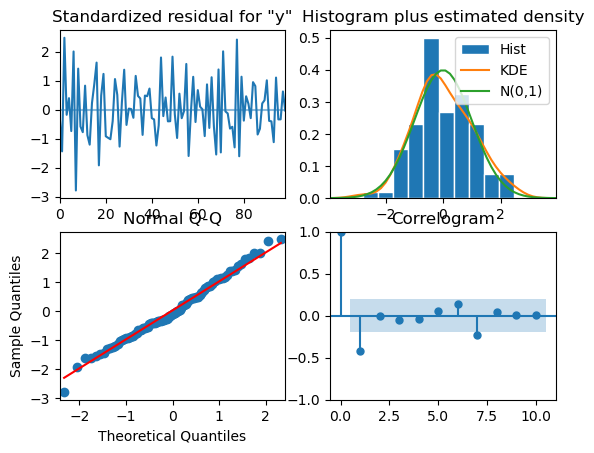

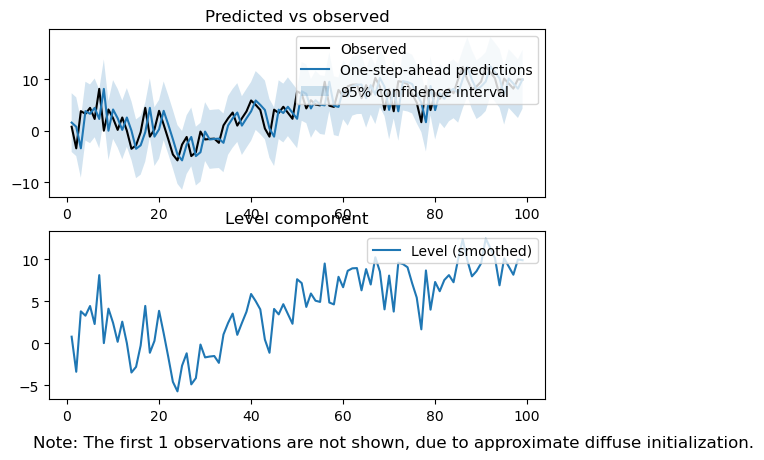

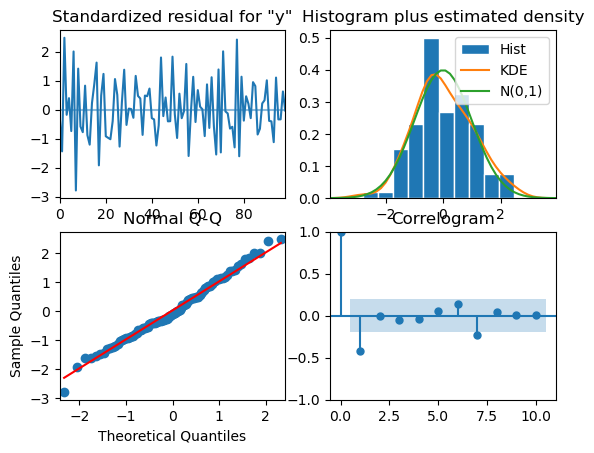

In [45]:
%matplotlib inline
model_res.plot_components()
model_res.plot_diagnostics()

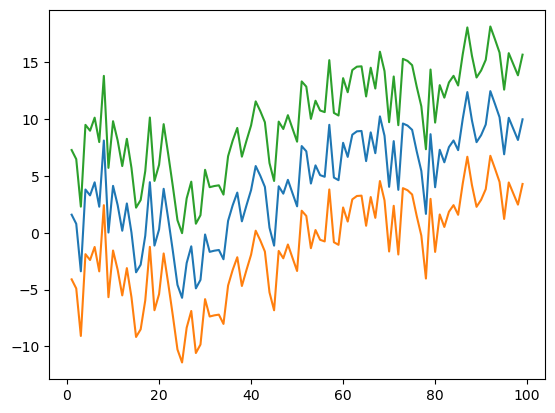

In [85]:
one_step = model_res.get_prediction().summary_frame()[['mean','mean_ci_lower','mean_ci_upper']]

plt.plot(one_step.iloc[1:,])

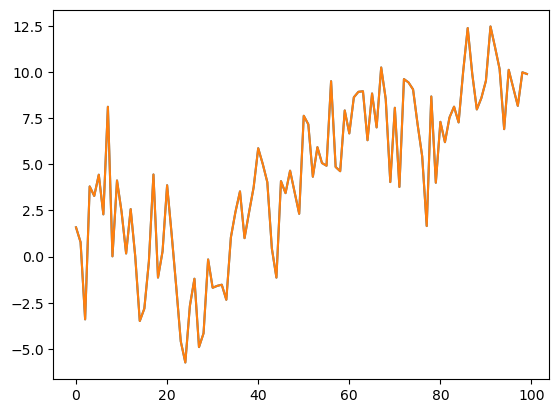

In [46]:
plt.plot(model_res.states.smoothed.flatten())
plt.plot(y)

In [93]:
def sim_seasonal(series_len, seasonality, duration=1, seed=None, seeded=False):
    """ get seasonal effects that sum to 0 over seasonal period"""
    
    if seeded:
        np.random.seed(seed)

    seas = []
    iterations = math.ceil(series_len / duration)
    init_seas = np.zeros(seasonality)

    init_seas[:-1] = np.random.normal(
        0, 1, seasonality - 1
    )

    init_seas[seasonality - 1] = -1 * np.sum(init_seas)
    for idx in range(iterations):
        seas += [init_seas[idx % seasonality]] * duration
    seas = np.array(seas[:series_len])
    
    return seas

def local_level_seasonal(num_timesteps=60, init_mu=1, 
                         s_obs = 3, s_mu=.1, 
                         seasonal_scale=.01, seasonality=12,
                         seasonal_variation = .5,
                         seeded=False, seed=None):

    if seeded:
        np.random.seed(seed)
    
    mu = np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)
    
    mu_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    obs_err = np.random.normal(loc=0, scale=1, size=num_timesteps)
    seasonal_err = np.random.normal(loc=0, scale=1, size=num_timesteps)

    # Get seasonal effects
    seasonal = sim_seasonal(num_timesteps, seasonality, 1, seed=seed, seeded=seeded) 
    seasonal = seasonal * seasonal_variation * init_mu

    mu[0] = init_mu

    for t in range(num_timesteps):
        mu[t+1] = mu[t] + s_mu * mu_err[t]
        seasonal[t] = seasonal[t] + seasonal_scale * seasonal_err[t]
        y[t] = mu[t] + seasonal[t] + s_obs * obs_err[t]

    return mu, y, seasonal

In [95]:
N = 100
s_obs = 2
s_level = 1
init_mu = 0

mu, y, seasonal = local_level_seasonal(
    num_timesteps=N, init_mu=init_mu, s_obs=s_obs, s_mu=s_level, 
    seeded=True, seed=5)

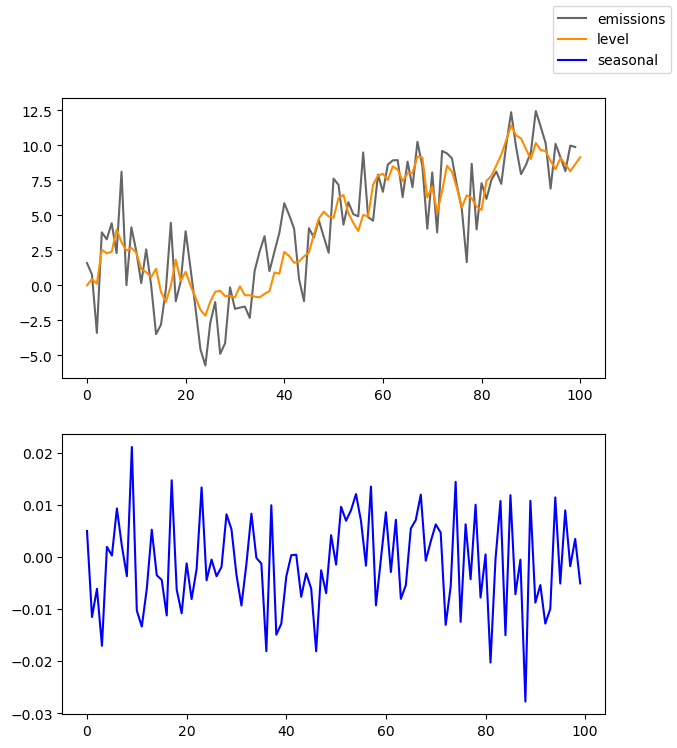

In [98]:
fig, ax = plt.subplots(2, figsize=(7,8))
ax[0].plot(y, label='emissions', color='k', alpha=.6)
ax[0].plot(mu, label = 'level', color='darkorange')
ax[1].plot(seasonal, label='seasonal', color="b")
fig.legend()